<a href="https://colab.research.google.com/github/itssofiarce/NLP-2025/blob/main/main_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Procesamiento del Lenguaje Natural - 2025

### Trabajo Práctico - Parte 2

Arce, Sofía.

## Preparación de entorno

In [ ]:
# Clonamos el reposotorio y el directorio de los datos
import os

REPO_NAME = "NLP-2025"
if REPO_NAME not in os.getcwd():
  if not os.path.exists(REPO_NAME):
    !git clone https://github.com/itssofiarce/{REPO_NAME}.git
  os.chdir(REPO_NAME)

Cloning into 'NLP-2025'...
remote: Enumerating objects: 127, done.
remote: Counting objects: 100% (127/127), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 127 (delta 26), reused 72 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (127/127), 12.08 MiB | 13.46 MiB/s, done.
Resolving deltas: 100% (26/26), done.


### Pre analísis de la información .txt

In [ ]:
# Texto mas extenso
longitud = {}
informacion = os.listdir('/content/NLP-2025/NLP_CASCADIA/datos/información')

for texto in informacion:
  contenido = open(f'/content/NLP-2025/NLP_CASCADIA/datos/información/{texto}', 'r')
  # Cuento solo las palabras

  longitud[texto] = len(contenido.read().split())

print(longitud)


{'whatboardgame_review.txt': 2288, 'oneboardfamily_review.txt': 1592, 'flatout_games.txt': 298, 'cascadia_manual.txt': 6734, 'board_game_co_uk_guide.txt': 127, 'bluehighwaygames_description.txt': 908, 'boardgamereview_review.txt': 2606}


En base al output de arriba el texto mas extenso es el manual de cascadia con 6734 palabras.



Para facilitar el desarrollo del Trabajo Práctico crearé la clase "TextoParaAnalizar" con los metodós necesarios para completar los enunciados.

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
# Funciones adicionales
def entorno_modelo(tipo_embedding):
  if tipo_embedding == "CountVectorizer":

    from sklearn.feature_extraction.text import CountVectorizer
    model = CountVectorizer()

  elif tipo_embedding == "sentencetransformer":
    !pip install -U sentence-transformers
    from sentence_transformers import SentenceTransformer
    model = SentenceTransformer('all-MiniLM-L6-v2')

  elif tipo_embedding == "spacy":
    import spacy
    model = spacy.load('en_core_web_sm')

  return model


In [ ]:
class TextoParaAnalizar:

  def __init__(self, text):
    # Validar path del archivo
    if not os.path.exists(text):
      raise Exception('El archivo no existe')
    self.text = text

  def __str__(self):
    """ Devuelve el contenido del texto """
    with open(self.text, 'r') as f:
      return f.read()

  def fragmentos(self, fragmento="palabra"):
    """ Devuelve una lista de fragmentos del texto.
      - "Fragmento: oracion"
      - "Fragmento: palabra"
    """
    import re
    texto_limpio = re.sub(r'[().!]', '', self.__str__())
    if fragmento == "oracion":
      texto_limpio =[line for line in texto_limpio.splitlines() if line.strip()]
      return texto_limpio
    return texto_limpio.split()


  def vectorizar(self, tipo: str = "sentencetransformer"):
    """ Vectoriza los fragmentos y los devuelve en un dataset. Por default usa ul modelo ContextDependent como word2vec.
        tipo:
        - "ContextDependent: CountVectorizer"
        - "ContextIndependent: "" sentencetransformer """
    import pandas as pd
    modelo = entorno_modelo(tipo)
    oraciones = self.fragmentos("oracion")
    embeddings = []

    if tipo == "CountVectorizer":
      X = modelo.fit_transform(oraciones)
      response_new = pd.DataFrame(X.toarray(), columns=modelo.get_feature_names_out())

    elif tipo == "sentencetransformer":
      response_new = modelo.encode(oraciones)
      #embeddings = modelo.encode(oraciones)
      #response_new = pd.DataFrame(embeddings.T, columns=oraciones)
    return response_new, modelo

  def extraer_sustantivos(self):
      """ Extrae los sustantivos de un texto. Part of Speech Tagging """


      modelo = entorno_modelo("spacy")
      oraciones = self.fragmentos("oracion")

      sustantivos_en_oraciones = []
      entidades_con_ner = {}
      sustantivos_en_oraciones_categorizados = {}

      for oracion in oraciones:
        doc = modelo(oracion)

        # NER
        for ent in doc.ents:
          if ent.text.lower() not in entidades_con_ner.keys():
            entidades_con_ner[ent.text.lower()] = ent.label_

        # POS
        for token in doc:
          if token.pos_ == "NOUN":
            sustantivo = token.text.lower()
            if sustantivo not in sustantivos_en_oraciones:
              sustantivos_en_oraciones.append(sustantivo)

        # Agreo al diccionario aquellos sustantivos que no fueron identificados como ner
        for sustantivo in sustantivos_en_oraciones:
          if sustantivo not in entidades_con_ner.keys():
            sustantivos_en_oraciones_categorizados[sustantivo] = ''

        # Junto ambos diccionarios
        sustantivos_en_oraciones_categorizados.update(entidades_con_ner)

      return sustantivos_en_oraciones_categorizados

## EJERCICIO 2
Apoyándose en la sección de información. Separa en fragmentos un texto extenso extraído y vectoriza cada fragmento con alguno de los modelos de embedding vistos en clases.

In [ ]:
texto_extenso = TextoParaAnalizar('/content/NLP-2025/NLP_CASCADIA/datos/información/cascadia_manual.txt')

In [ ]:
# Separo en palabras y vectorizo
dataframe, model = texto_extenso.vectorizar("sentencetransformer")

Luego realiza un análisis de similitud de texto ingresando varias frases a buscar semánticamente, compare distintas técnicas de distancias vistas en clases, elija la mejor y justifique la razón por la que esa técnica se ajusta para este tipo de búsquedas.



In [ ]:
# Calcular la similutid del coseno entre las frases_ejemplo y todo el texto.
from sentence_transformers import util
frases_ejemplo=["Casadia is a game", "There are only 3 types of Wildlife cards", "Casadia ia a geographic region"]
frases_ejemplo_vectorizadas = model.encode(frases_ejemplo)

In [ ]:
to_plot_coincidencias=[]
to_plot_coincidencias_vectorizadas=[]

In [ ]:
for i, frase in enumerate(frases_ejemplo):
    similitudes = util.cos_sim(frases_ejemplo_vectorizadas[i], dataframe)
    print(f"\nFrase ejemplo: '{frase}'")
    # Mostrar las frases del texto más similares a esta
    resultados_ordenados = similitudes[0].argsort(descending=True)
    for idx in resultados_ordenados[:3]:  # Top 3 resultados
        # Busco por idx la oracion original
        to_plot_coincidencias.append(texto_extenso.fragmentos("oracion")[idx])
        to_plot_coincidencias_vectorizadas.append(dataframe[idx])
        oracion_similar = texto_extenso.fragmentos("oracion")[idx.item()]
        print(f" → {oracion_similar} (Similitud: {similitudes[0][idx]:.4f})")


Frase ejemplo: 'Casadia is a game'
 → Set up and play a multi-player game of Cascadia using the  (Similitud: 0.5859)
 → Set up and play a multi-player game of Cascadia following  (Similitud: 0.5751)
 → The Flatout Games CoLab for Cascadia is: (Similitud: 0.5627)

Frase ejemplo: 'There are only 3 types of Wildlife cards'
 → Only have 3 types of Wildlife (Similitud: 0.7758)
 → 1 Wildlife Scoring Cards (Similitud: 0.7268)
 → 1 Wildlife Scoring Cards (Similitud: 0.7268)

Frase ejemplo: 'Casadia ia a geographic region'
 → About the Region (Similitud: 0.5014)
 → landmarks in the region (Similitud: 0.4970)
 → wild places wherever you may be, or consider paying Cascadia a visit (Similitud: 0.4175)


In [ ]:
# Similitud de Jaccard
def jaccard_similarity(str1, str2):
    set1 = set(str1.lower().split())
    set2 = set(str2.lower().split())
    return len(set1 & set2) / len(set1 | set2) if set1 | set2 else 0

In [ ]:
from sentence_transformers import util

frases_ejemplo = ["Casadia is a game", "There are only 3 types of Wildlife cards", "Casadia ia a geographic region"]

for i, frase in enumerate(frases_ejemplo):
    print(f"\nFrase ejemplo: '{frase}'")

    # Calculate Jaccard similarity for each fragment in the text
    similitudes_jaccard = [jaccard_similarity(frase, oracion) for oracion in texto_extenso.fragmentos("oracion")]

    # Get the indices of the top 3 most similar sentences
    resultados_ordenados_jaccard = sorted(range(len(similitudes_jaccard)), key=lambda i: similitudes_jaccard[i], reverse=True)[:3]

    # Print the top 3 most similar sentences and their Jaccard similarities
    for idx in resultados_ordenados_jaccard:
        oracion_similar = texto_extenso.fragmentos("oracion")[idx]
        print(f" → {oracion_similar} (Similitud Jaccard: {similitudes_jaccard[idx]:.4f})")


Frase ejemplo: 'Casadia is a game'
 → This tile is a Keystone  (Similitud Jaccard: 0.2857)
 → A (Similitud Jaccard: 0.2500)
 → A (Similitud Jaccard: 0.2500)

Frase ejemplo: 'There are only 3 types of Wildlife cards'
 → Only have 3 types of Wildlife (Similitud Jaccard: 0.5556)
 → If 3 of the available Wildlife Tokens are the same, then  (Similitud Jaccard: 0.2857)
 → Overpopulation: 3 of the same Wildlife Token (Similitud Jaccard: 0.2500)

Frase ejemplo: 'Casadia ia a geographic region'
 → A (Similitud Jaccard: 0.2000)
 → A (Similitud Jaccard: 0.2000)
 → A (Similitud Jaccard: 0.2000)


OPCIONAL: Visualizar en 3D aplicando PCA o t-SNE la ubicación de los fragmentos y la query ingresada vectorizada en el espacio. Realizar una observación sobre la visualización.


In [ ]:
!pip install plotly

In [ ]:
import plotly.graph_objects as go
from sklearn.decomposition import PCA
import numpy as np

# Initialize lists to store all data points for PCA
all_vectores = []
all_oraciones = []
all_colores = []

for i, frase in enumerate(frases_ejemplo):
    similitudes = util.cos_sim(frases_ejemplo_vectorizadas[i], dataframe)
    print(f"\nFrase ejemplo: '{frase}'")

    resultados_ordenados = similitudes[0].argsort(descending=True)

    # Store data for current phrase
    all_oraciones.append(frase)  # include the example phrase
    all_vectores.append(frases_ejemplo_vectorizadas[i])
    all_colores.append('red')

    for idx in resultados_ordenados[:3]:
        oracion_similar = texto_extenso.fragmentos("oracion")[idx.item()]
        print(f" → {oracion_similar} (Similitud: {similitudes[0][idx]:.4f})")

        # Store data for similar sentences
        all_oraciones.append(oracion_similar)
        all_vectores.append(dataframe[idx.item()])
        all_colores.append('blue')


# Apply PCA to all collected data points
pca = PCA(n_components=3)
vectores_3d = pca.fit_transform(np.array(all_vectores))
x, y, z = vectores_3d[:, 0], vectores_3d[:, 1], vectores_3d[:, 2]
hover_text = [f"{j}: {sent}" for j, sent in enumerate(all_oraciones)]

# Create a single plot with all data points
fig = go.Figure()
fig.add_trace(go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers+text',
    marker=dict(
        size=6,
        color=all_colores,
        opacity=0.8
    ),
    text=[str(j) for j in range(len(all_oraciones))],
    hovertext=hover_text,
    hoverinfo='text'
))

fig.update_layout(
    title='Visualización de Frases Ejemplo y Similares',
    scene=dict(
        xaxis_title='PC 1',
        yaxis_title='PC 2',
        zaxis_title='PC 3'
    ),
    showlegend=False
)

fig.show()


Frase ejemplo: 'Casadia is a game'
 → Set up and play a multi-player game of Cascadia using the  (Similitud: 0.5859)
 → Set up and play a multi-player game of Cascadia following  (Similitud: 0.5751)
 → The Flatout Games CoLab for Cascadia is: (Similitud: 0.5627)

Frase ejemplo: 'There are only 3 types of Wildlife cards'
 → Only have 3 types of Wildlife (Similitud: 0.7758)
 → 1 Wildlife Scoring Cards (Similitud: 0.7268)
 → 1 Wildlife Scoring Cards (Similitud: 0.7268)

Frase ejemplo: 'Casadia ia a geographic region'
 → About the Region (Similitud: 0.5014)
 → landmarks in the region (Similitud: 0.4970)
 → wild places wherever you may be, or consider paying Cascadia a visit (Similitud: 0.4175)


de la teoria:: Los métodos Count Vectorizer y TF-IDF capturan la aparición o frecuencia de palabras. Si bien admiten el uso
de similitud de coseno, la cercanía estará dada por las similitudes en cuanto a la presencia o cuenta de las
mismas palabras, y no por su similitud semántica o de contexto, como en el caso de los modelos de
embeddings.


## EJERCICIO 3
Apoyándose nuevamente en la sección de información. Recoge un texto extenso extraído, divídelos en fragmentos, luego realiza extracciones de sustantivos (POS) y categoriza estos sustantivos (NER), a continuación realiza una búsqueda de similitud filtrando por sustantivos, compara las distintas técnicas de distancias vistas en clases, elija la mejor y justifique la razón por la que esta técnica se ajusta para este tipo de búsquedas.


{
  "sustantivo_nombre": [[lista de ent que contienen el sustantivo_nombre], ent]
}

In [ ]:
texto_extenso_2 = TextoParaAnalizar('/content/NLP-2025/NLP_CASCADIA/datos/información/oneboardfamily_review.txt')

In [ ]:
# Separo en frases y me creo un dataframe con los vectores de los fragmentos
dataframe2, model2 = texto_extenso_2.vectorizar("sentencetransformer")

In [ ]:
# Extraigo los sustantivos y los clasifico segun si tienen entidad en el mundo real
sustantivos_clasificados = texto_extenso_2.extraer_sustantivos()

In [ ]:
# Crear un dataframe con los sustantivos y sus embedings
dataframe_sustantivos = pd.DataFrame()
# Si se trata de un sustantivo compuesto de mas de una palabra, se genera un nuevo vector.
for key in sustantivos_clasificados.keys():
  if key not in dataframe_sustantivos.columns:
    vector_sustantivo_compuesto = model2.encode(key)
    dataframe_sustantivos[key] = vector_sustantivo_compuesto

<ipython-input-86-3bf0d406557c>:7: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-86-3bf0d406557c>:7: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-86-3bf0d406557c>:7: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-86-3bf0d406557c>:7: PerformanceWarning:

Da

In [ ]:
# Función para calcular la similitud del coseno
def cosine_similarity(vec1, vec2):
  return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

In [ ]:
# Calcular la similitud del coseno entre dos sustantivos
similarity = cosine_similarity(dataframe_sustantivos['search'],dataframe_sustantivos['designers'])
print(f"\nSimilitud del coseno entre 'search' y 'designers': {similarity}")


Similitud del coseno entre 'search' y 'designers': 0.2140672206878662


In [ ]:
# ¿Cuáles son los primeros cinco sustantivos mas parecidos a "game"? con similitud del coseno
sustantivos_similares = {}
for sustantivo in dataframe_sustantivos.columns:
  similitud = cosine_similarity(dataframe_sustantivos[sustantivo], dataframe_sustantivos['game'])
  # Convertir the numpy.float32 a python float
  sustantivos_similares[sustantivo] = float(similitud)

sustantivos_similares_ordenados = dict(sorted(sustantivos_similares.items(), key=lambda item: item[1], reverse=True))

for i, (sustantivo, similitud) in enumerate(sustantivos_similares_ordenados.items()):
    if i < 10:
        print(f"- '{sustantivo}': {similitud:.4f}")
    else:
        break

- 'game': 1.0000
- 'games': 0.8269
- 'board game': 0.7007
- 'gaming': 0.6966
- 'card game': 0.6893
- 'board games': 0.6361
- 'player': 0.6291
- 'gamer': 0.6242
- 'party games': 0.6160
- 'card games': 0.6149


In [ ]:
# Función para calcular la distancia eudclideana
def euclidean_distance(vec1, vec2):
  return np.linalg.norm(vec1 - vec2)


In [ ]:
# Calcular la similitud del coseno entre dos sustantivos con la distancia euclideana
euclidean_similarity = euclidean_distance(dataframe_sustantivos['search'],dataframe_sustantivos['designers'])
print(f"\nDistancia euclideana entre 'search' y 'designers': {euclidean_similarity}")


Distancia euclideana entre 'search' y 'designers': 1.253740668296814


In [ ]:
# ¿Cuáles son los primeros cinco sustantivos mas parecidos a "game"? con distancia euclideana
sustantivos_similares_eucli = {}
for sustantivo in dataframe_sustantivos.columns:
  similitud = euclidean_distance(dataframe_sustantivos[sustantivo], dataframe_sustantivos['game'])
  # Convertir the numpy.float32 a python float
  sustantivos_similares_eucli[sustantivo] = float(similitud)

sustantivos_similares_eucli_ordenados = dict(sorted(sustantivos_similares_eucli.items(), key=lambda item: item[1], reverse=False))

for i, (sustantivo, similitud) in enumerate(sustantivos_similares_eucli_ordenados.items()):
    if i < 10:
        print(f"- '{sustantivo}': {similitud:.4f}")
    else:
        break

- 'game': 0.0000
- 'games': 0.5884
- 'board game': 0.7736
- 'gaming': 0.7789
- 'card game': 0.7883
- 'board games': 0.8531
- 'player': 0.8613
- 'gamer': 0.8670
- 'party games': 0.8763
- 'card games': 0.8776


## EJERCICIO 4
Mediante detección de idioma, separar los archivos en distintos lenguajes y guardar esa
información en un dataframe.


In [ ]:
!pip install langdetect

In [ ]:
import os
from langdetect import detect, LangDetectException

def detect_language(text_path):
    try:
        with open(text_path, 'r', encoding='utf-8') as file:
            text = file.read()
            return detect(text)
    except LangDetectException:
        return "unknown"  # En caso de que falle al detectar el idioma
    except Exception as e:
        print(f"Error processing {text_path}: {e}")
        return "error"


# Directorio que contiene los archivos de texto
directorio_informacion = '/content/NLP-2025/NLP_CASCADIA/datos/información'

# Lista para almacenar la información de los archivos
datos_archivos = []

for filename in os.listdir(directorio_informacion):
    if filename.endswith(".txt"):
        ruta_completa = os.path.join(directorio_informacion, filename)
        idioma = detect_language(ruta_completa)
        datos_archivos.append([filename, idioma])


# Crear un DataFrame de pandas
df_idiomas = pd.DataFrame(datos_archivos, columns=["Nombre del archivo", "Idioma"])

df_idiomas


,Nombre del archivo,Idioma
0,whatboardgame_review.txt,en
1,oneboardfamily_review.txt,en
2,flatout_games.txt,en
3,cascadia_manual.txt,en
4,board_game_co_uk_guide.txt,en
5,bluehighwaygames_description.txt,en
6,boardgamereview_review.txt,en


##EJERCICIO 5
En el caso de las reseñas realizadas por usuarios, utiliza análisis de sentimientos con modelos pre entrenados y guarda la clasificación predecida de cada reseña.

Luego, crea un sistema de búsquedas por similitud semántica y que permita filtrar por sentimiento para obtener.


In [ ]:
!pip install transformers

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline

In [ ]:
# Cargamos el tokenizador y el modelo
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)

In [ ]:
# Creamos un pipeline de clasificación
nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

Device set to use cpu


In [ ]:
frases = texto_extenso_2.fragmentos('oracion')

In [ ]:
# Separar fragmentos segun sentimiento:
def analisis_de_sentimiento(fragmentos):

  # Obtenemos las predicciones de sentimiento para cada fragmento
  reviews_analizadas = {
      'Negativo': [],
      'Neutral': [],
      'Positivo': []
  }

  reviews = []
  for i, frase in enumerate(fragmentos):

    # Descarto aquellas que no esten relacionadas con una review (si su longitud es menor a 5 palabras)
    if len(frase.split()) < 5:
      continue
    else:
      result = nlp(frase)
      sentiment_label = result[0]['label']
      score = result[0]['score']

      # agrego a mi frase a mi dataframe para posterior busqueda
      reviews.append(frase)

      # Clasifico las 'estrellas' en tres categorias: 1-2 --> Negativo, 3 --> Neutral, 4-5 --> Positiva
      if sentiment_label in ['1 star', '2 stars']:
          reviews_analizadas['Negativo'].append(frase)
      elif sentiment_label == '3 stars':
          reviews_analizadas['Neutral'].append(frase)
      elif sentiment_label in ['4 stars', '5 stars']:
          reviews_analizadas['Positivo'].append(frase)

  return reviews_analizadas

In [ ]:
def busqueda_semantica(consultas, respuestas, model, value={}):

  # If there are optional arguments then we need to load review_analizadas, promptear un sentimiento de la lista para filtrar? segun la respuesta que se desea que tenga ese sentimiento.
  if value is not busqueda_semantica.__defaults__[0]:
    respuestas_separadas = analisis_de_sentimiento(respuestas)
    respuestas = respuestas_separadas[value]

  incrustaciones_respuestas = model.encode(respuestas)
  resultados_busqueda = {}
  incrustaciones_consultas = model.encode(consultas)

  for i, incrustacion_consulta in enumerate(incrustaciones_consultas):
    similitudes = util.cos_sim(incrustacion_consulta, incrustaciones_respuestas)
    mejor_indice = similitudes.argmax()
    resultados_busqueda[f'{i}'] = {'Consulta': consultas[i], 'Mejor respuesta': respuestas[mejor_indice], 'Similitud': similitudes[0][mejor_indice]}

  return resultados_busqueda



In [ ]:
# Luego, crea un sistema de búsquedas por similitud semántica y que permita filtrar por sentimiento para obtener.
consultas = ['Is the game easy?', 'How cool is the game?', 'Can children play?', 'Does Casadia have a terrible design?', 'Does the game have a terrible design?']

In [ ]:
busqueda_semantica(consultas, frases, model2)

{'0': {'Consulta': 'Is the game easy?',
  'Mejor respuesta': ' is a very straightforward game The rules may, in fact, be the most simple of any game that I’ve reviewed in a while\xa0',
  'Similitud': tensor(0.7225)},
 '1': {'Consulta': 'How cool is the game?',
  'Mejor respuesta': 'Nothing particularly new or innovative about the game',
  'Similitud': tensor(0.5545)},
 '2': {'Consulta': 'Can children play?',
  'Mejor respuesta': 'Kid Friendly Games',
  'Similitud': tensor(0.6547)},
 '3': {'Consulta': 'Does Casadia have a terrible design?',
  'Mejor respuesta': 'Cascadia Review',
  'Similitud': tensor(0.4316)},
 '4': {'Consulta': 'Does the game have a terrible design?',
  'Mejor respuesta': 'So what the game aims to do, the game does well, and that’s really all I can ask of the designers It’s also very versatile I could play this game with a bunch of newer gamers, or I could break this out at a gaming convention In both scenarios, I think everyone would enjoy themselves',
  'Similitud':

In [ ]:
busqueda_semantica(consultas, frases, model2, 'Negativo')

{'0': {'Consulta': 'Is the game easy?',
  'Mejor respuesta': ' a while back This time was really bad, though, as I actually didn’t even remember that I bought the game until it arrived When I started reading the rules, I again was disappointed, thinking that I’d sunk quite a bit of money into something I wasn’t going to enjoy',
  'Similitud': tensor(0.4225)},
 '1': {'Consulta': 'How cool is the game?',
  'Mejor respuesta': 'Nothing particularly new or innovative about the game',
  'Similitud': tensor(0.5545)},
 '2': {'Consulta': 'Can children play?',
  'Mejor respuesta': 'One Board Interview: Carla Kopp, Weird Giraffe Games',
  'Similitud': tensor(0.2633)},
 '3': {'Consulta': 'Does Casadia have a terrible design?',
  'Mejor respuesta': 'Nothing particularly new or innovative about the game',
  'Similitud': tensor(0.3054)},
 '4': {'Consulta': 'Does the game have a terrible design?',
  'Mejor respuesta': 'Nothing particularly new or innovative about the game',
  'Similitud': tensor(0.531

## EJERCICIO 6
Crea un set de datos de consultas (más de 300 preguntas en total) y categorizalas entre la
fuente de datos que pueda llegar a responder esa pregunta entre estadísticas,
información y relaciones.
Por ejemplo:
- ¿Cómo gano en el ajedrez? -> Información
- ¿Quién trabajó para el ta-te-ti? -> Relaciones
- ¿Qué puntaje tienen las damas? -> Estadística

A continuación, transforma esas consultas en vectores y entrena un modelo de clasificación
(a gusto del estudiante) en donde pueda predecir la categoría a través de la consulta
ingresada.
Agregar métricas y análisis durante todo el desarrollo, trabaje en varios modelos y
comparelos.

El dataset fue generado con la ayuda de chatgpt y las siguientes prompts:
- Genera unas 110 Preguntas distintas que se puedan responder con información de un juego
- Genera 110 preguntas distintas que respondan a interrogantes relacionados a estadisticas de un Juego
- Genera 110 preguntas distintas que respondan a interrogantes de personas involucradas en la gestion, producción, diseño etc. de un juego

Elige entre difentes juegos de amplio conocimiento universal.

Luego, agregué 10 preguntas mas a cada categoría. Osea, en total hay 330 preguntas. 1**10 por cada "categoria"** por lo que esto garantiza que nuestro **dataset** está **balanceado**.

Para la generacion de vectores se uso el modelo de "sentence transformer" utilizado en los ejercicios anteriores.

Para la clasificación seleccioné dos modelos:
 - scikit-learn: Support Vector Machines
 - Regresion logística

## Preparacion de los datos - csv a pdf y generar embeddings


In [ ]:
# Pasar el csv a dataframe
df = pd.read_csv('/content/NLP-2025/tp-nlp-preguntas - preguntas_personas_110.csv')

In [ ]:
# Split train-test 80-20
from sklearn.model_selection import train_test_split

X = df['Pregunta']
y = df['Tipo']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((197,), (50,), (197,), (50,))

In [ ]:
# Vectorizo mis consultas
x_train_vectores = model2.encode(x_train.tolist())
x_test_vectores = model2.encode(x_test.tolist())


## Support Vector Machines

In [ ]:
from sklearn import svm

In [ ]:
clf = svm.SVC()

In [ ]:
# Fit the classifier using the vectorized training data
clf.fit(x_train_vectores, y_train)

SVC()

In [ ]:
predicciones = clf.predict(x_test_vectores)

In [ ]:
print("Predicciones del test set:")
# Iterate through the test set and print the original question and its prediction
for i in range(len(x_test)):
    print(f"'{x_test.iloc[i]}' -> Categoria Predicha: {predicciones[i]} - Catergoria: {y_test.iloc[i]}")

Predicciones del test set:
'¿Qué equipo diseñó el sistema de batallas en Pokémon?' -> Categoria Predicha: INFORMACION - Catergoria: RELACIONES
'¿Quién fue el creador del alfabeto usado en Scrabble?' -> Categoria Predicha: RELACIONES - Catergoria: RELACIONES
'¿Cómo se vota en Among Us?' -> Categoria Predicha: INFORMACION - Catergoria: INFORMACION
'¿Cuál es el porcentaje de jugadores de ajedrez que termina en tablas?' -> Categoria Predicha: ESTADÍSTICAS - Catergoria: ESTADÍSTICAS
'¿Qué cartas se usan en Pokémon TCG?' -> Categoria Predicha: INFORMACION - Catergoria: INFORMACION
'¿Qué significa 'Creative Mode' en Minecraft?' -> Categoria Predicha: INFORMACION - Catergoria: INFORMACION
'¿Cuántas fichas tiene cada jugador en Scrabble?' -> Categoria Predicha: ESTADÍSTICAS - Catergoria: INFORMACION
'¿Cuántas batallas hay en una aventura de Pokémon?' -> Categoria Predicha: ESTADÍSTICAS - Catergoria: ESTADÍSTICAS
'¿Quiénes crearon Pokémon?' -> Categoria Predicha: RELACIONES - Catergoria: RELACIO

### Analisis de los resultados de Support Vector Machine

In [ ]:
from sklearn import metrics

print("Accuracy:",metrics.accuracy_score(y_test, predicciones))

# Model Precision: what percentage of positive tuples are labeled as such?
# Specify 'average' for multiclass data
print("Precision:",metrics.precision_score(y_test, predicciones, average='weighted'))

# Model Recall: what percentage of positive tuples are labelled as such?
# Specify 'average' for multiclass data
print("Recall:",metrics.recall_score(y_test, predicciones, average='weighted'))

Accuracy: 0.8
Precision: 0.8238461538461539
Recall: 0.8


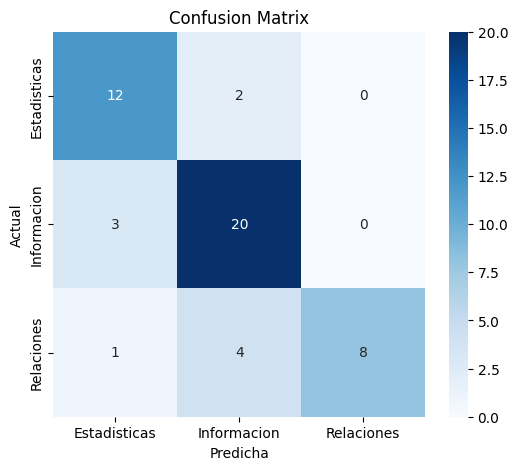

In [ ]:
# Plotear una Matriz de confusion
cm = metrics.confusion_matrix(y_test, predicciones)
clases = ['Estadisticas', 'Informacion', 'Relaciones']

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=clases,
            yticklabels=clases)
plt.ylabel('Actual')
plt.xlabel('Predicha')
plt.title('Confusion Matrix')
plt.show()



## Regresion logística

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
clf2 = LogisticRegression(random_state=0).fit(x_train_vectores, y_train)

In [ ]:
predicciones_lr = clf2.predict(x_test_vectores)

In [ ]:
clf2.score(x_test_vectores, y_test)

0.68

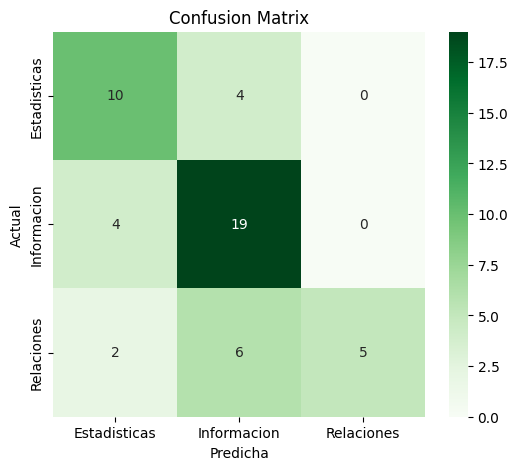

In [ ]:
cm2 = metrics.confusion_matrix(y_test, predicciones_lr)
clases = ['Estadisticas', 'Informacion', 'Relaciones']

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 5))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Greens',
            xticklabels=clases,
            yticklabels=clases)
plt.ylabel('Actual')
plt.xlabel('Predicha')
plt.title('Confusion Matrix')
plt.show()

